Once that standard suite of calibrations have been performed, we need to subtract off light contamination from background sources. The trickiest aspect of this calibration is trying to interpolate how bright the background is over the region of pixels that our signal trace spans. If your spectrograph is well-behaved, then all wavelengths will fall at a single location along the dispersion axis. Real spectrographs are rarely this ideal.

Here, we discuss how ```specsuite``` models distortions in an image and the methods used to correct them.

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        Each documentation page builds upon tools used in the prior section. To make each page easy to read, the code used to set up each page has been hidden. If you would like to see the code block we are running to initialize each page, you can use the <strong>"Show Setup Code"</strong> button.
    </p>
</div>

In [1]:
import specsuite as ss

# Defines where to look for data
DATA_REGION = (700, 800)
CAL_PATH = "../data/KOSMOS/calibrations"
DATA_PATH = "../data/KOSMOS/target"
INSTRUMENT = "kosmos"

# Collects all the necessary exposures
bias = ss.average_matching_files(
    path = CAL_PATH,
    tag = "bias",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT
)

arclamp = ss.average_matching_files(
    path = CAL_PATH,
    tag = "neon",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
) - bias

science = ss.collect_images_array(
    DATA_PATH,
    "toi3884",
    crop_bds=DATA_REGION,
    instrument = INSTRUMENT,
) - bias

## Basic Usage
### _Finding Line Emissions_
Arclamps produce distinct line emissions depending on which element they are filled with. In order to perform a wavelength calibration, we first need a list of pixel locations that line emissions appear at. <span class="specsuite-text"><code>specsuite</code></span> does this by looking for pixels that have a value that exceeds some multiple of the **[mean-averaged deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation)** above the median. So, if we wanted to flag all lines with an intensity 50x greater than the median, we could use the following code...

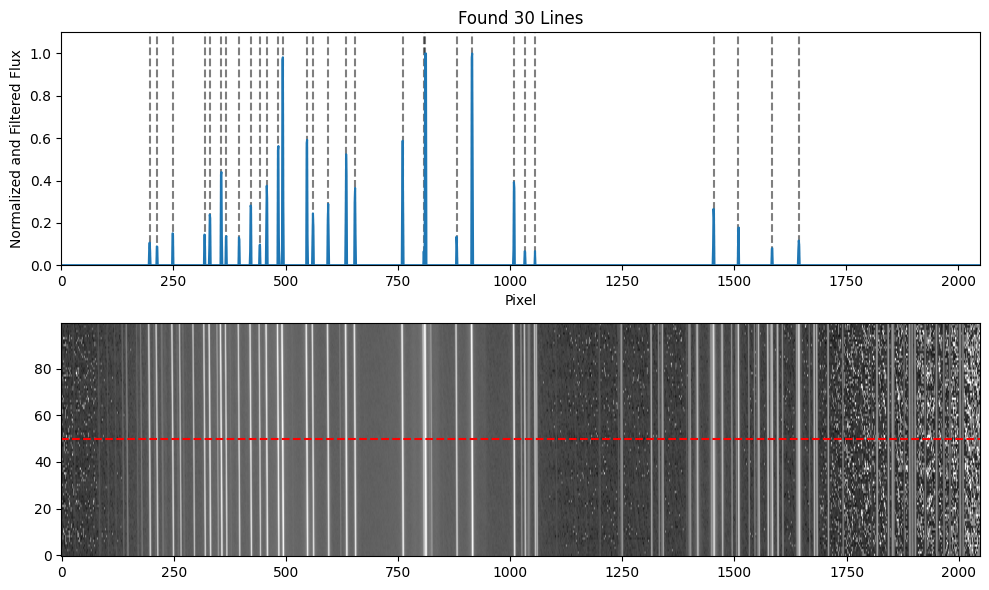

In [2]:
line_locations, line_intensities = ss.find_cal_lines(
    image = arclamp,
    std_variation = 200,
    debug = True,
)

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        If multiple adjacent pixels exceed the provided threshold, they will be combined into a single line at the mean of their locations. When the provided threshold is too low, this can result in several distinct lines being lumped into a single, effective location.
    </p>
</div>

### _Generating a "Warp Model"_
Several <span class="specsuite-text"><code>specsuite</code></span> functions use a <strong>warp model</strong> that describes how straight, vertical lines are curved along the dectector. Specifically, if we assume that a line emission takes on the shape of an Nth-order polynomial, then the shape of each line emission at a given dispersion-axis location (x) is...

\begin{equation*}
    W(x) = \sum_{i=0}^N c_i(x) \cdot x^i
\end{equation*}

where each coefficient is a separate Mth-order polynomial (these describe how the line shape changes across the detector). As you can imagine, this can be a difficult model to build. However, using the line emission features contained in an arclamp image, we can automate how we generate warp models!

We use ```scipy.signal``` to measure the **[cross-correlation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlation_lags.html)** between rows. This gives us a list of "lags" between rows that traces out the same curvature as our original signal. By fitting an Nth-order polynomial to these "lag curves", we can approximate the shape of spectral lines in that region of the detector. Then, we fit a separate Mth-order polynomial to each fitting consant to model how these line change shape along the dispersion axis.

In the simplest situation, you just need to provide the arclamp image and the approximate locations of line emissions in that image. Using the line locations from ```find_cal_lines()```...

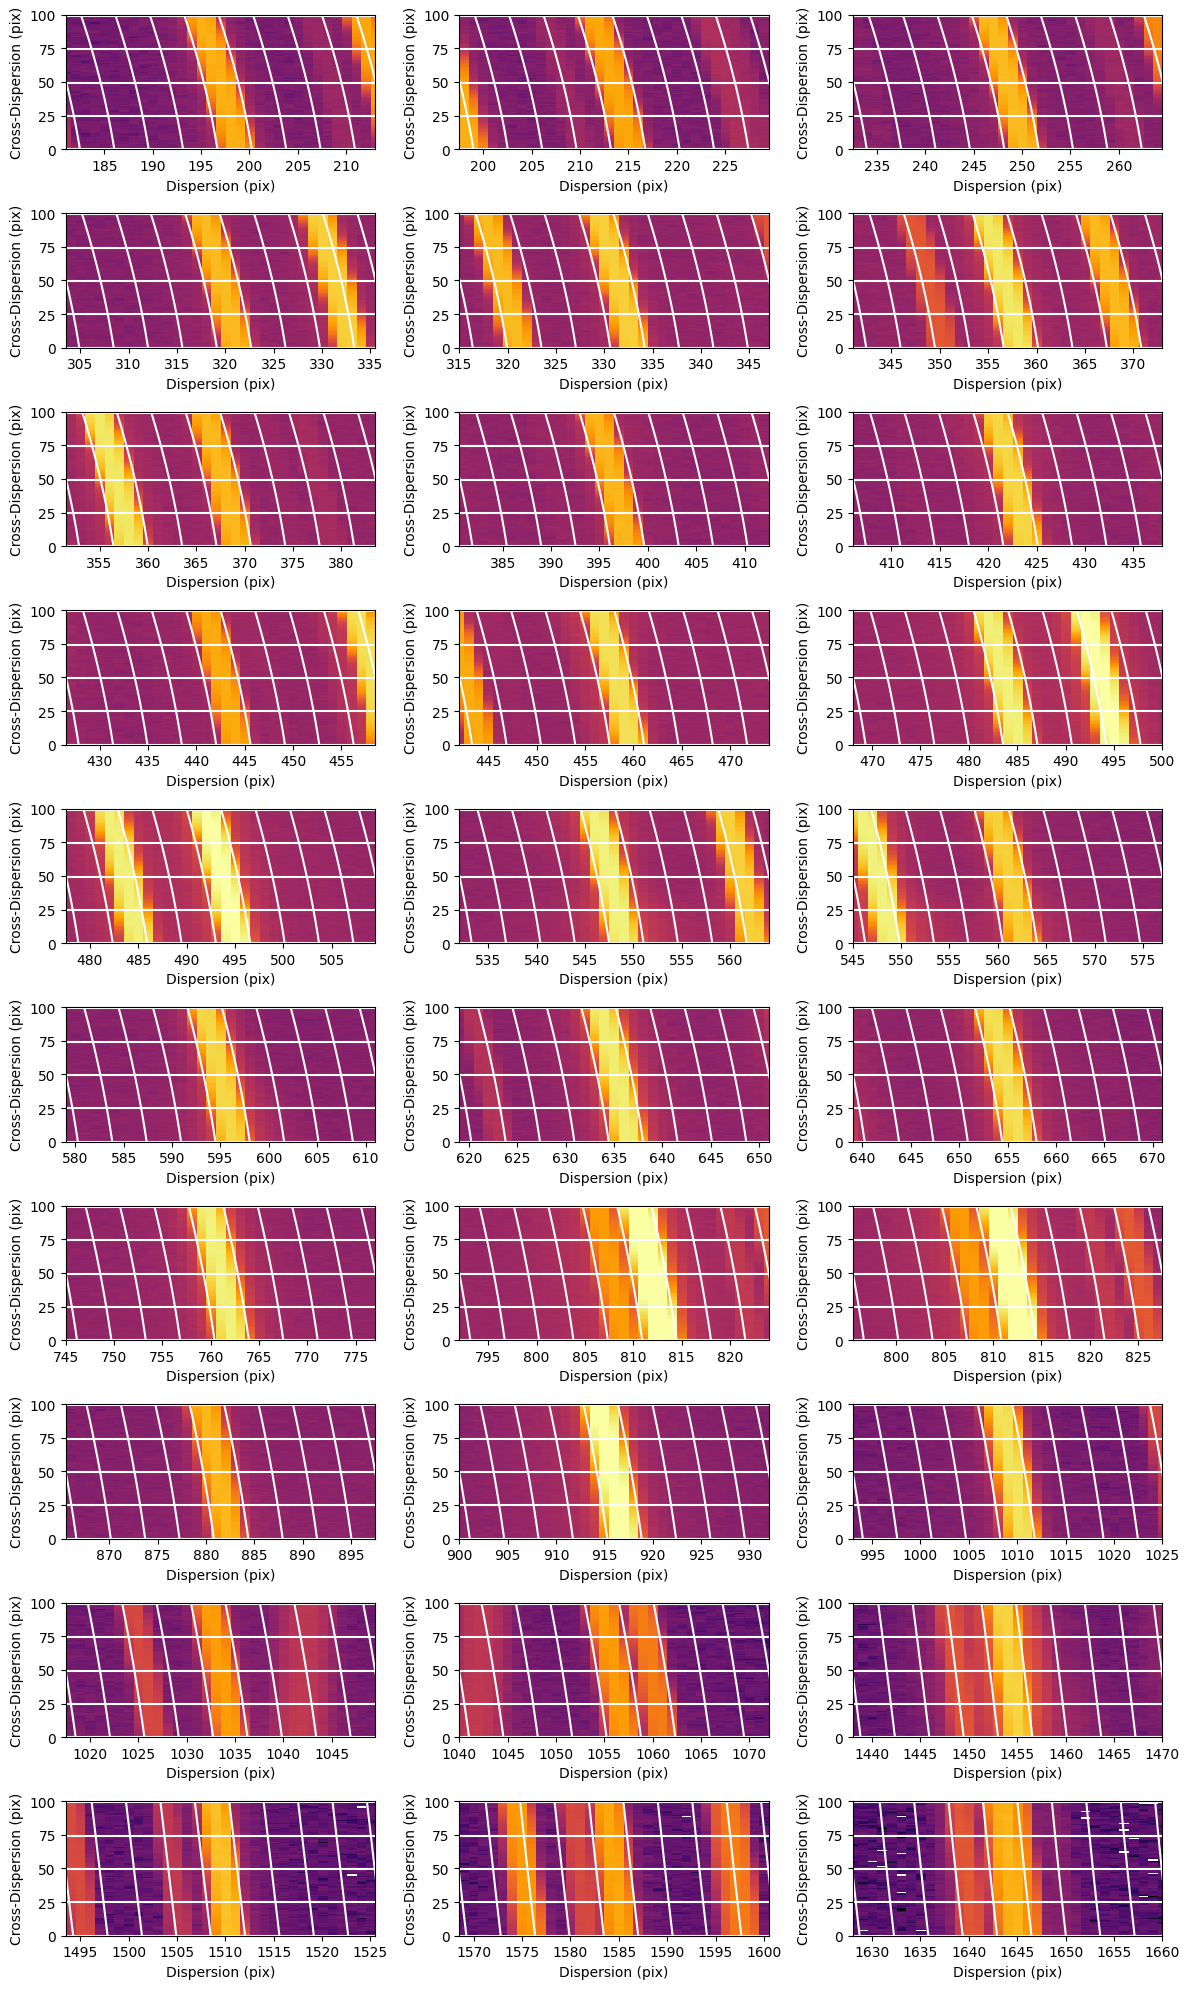

In [3]:
models = ss.generate_warp_model(
    image = arclamp,
    guess = line_locations,
    debug = True,
)

This large plot zooms in to each line provided in ```guess``` and overplots the fitted warp model. As long as the white grid's curvature seems to mirror that of the line emissions, then the warp model was generated correctly!

### _Fixing Warped Images_
One potential use for a warp model is to "de-warp" an image. Essentially, this tries to re-distribute pixel counts in a way that accounts for the contorted pixel grid (a practice known as **[coordinate rectification](https://en.wikipedia.org/wiki/Image_rectification)**). If the warp model is good, then the curved line emissions in our arclamp image should be straightened out...

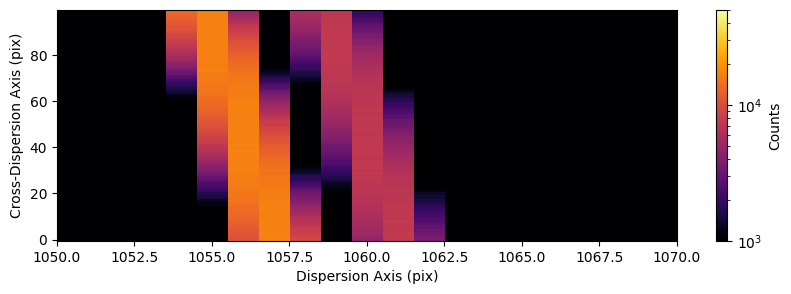

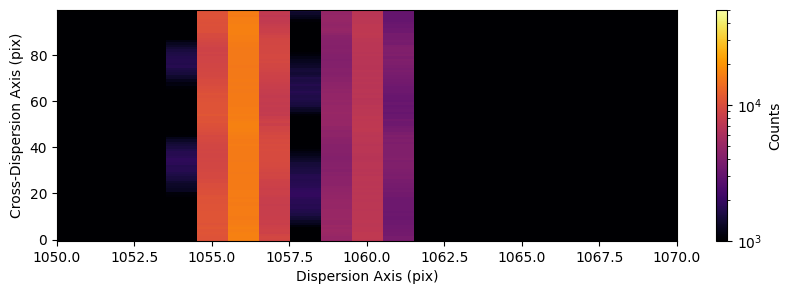

In [4]:
fixed_arc = ss.dewarp_image(image = arclamp, models = models)

ss.plot_image(
    arclamp,
    norm='log',
    xlim=(1050, 1070),
    vmin=1e3,
    vmax=5e4,
)

ss.plot_image(
    fixed_arc,
    norm='log',
    xlim=(1050, 1070),
    vmin=1e3,
    vmax=5e4,
)

This warp model should apply to more than just your arclamp image, though! For example, we can use it to straighten out a science exposure...

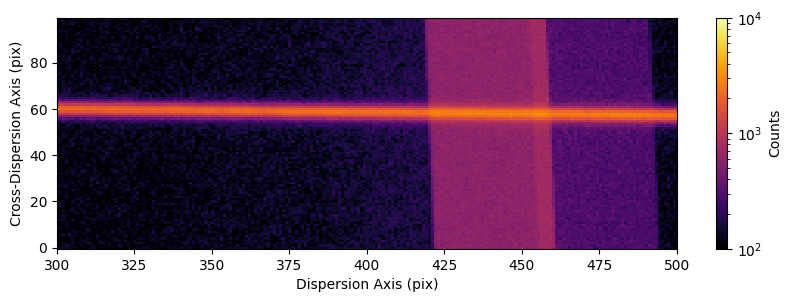

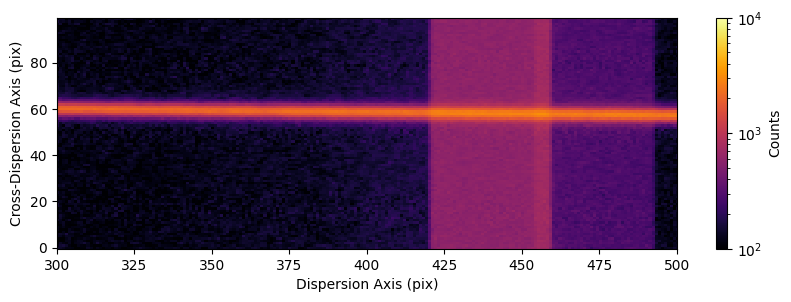

In [5]:
# Applies warp model to a single science image
fixed_science = ss.dewarp_image(science[0], models)

# Plots the 'before' and 'after' sub-images
ss.plot_image(science[0], norm='log', xlim=(300, 500), vmin=1e2, vmax=1e4)
ss.plot_image(fixed_science, norm='log', xlim=(300, 500), vmin=1e2, vmax=1e4)

<div class="admonition warning">
    <p class="admonition-title">Warning</p>
        <p>
            We do not recommend using <strong>dewarp_image()</strong> for anything other than visual inspection. This is because the coordinate rectification technique produces faint aliasing artifacts that could easily be mistaken for an astronomical signal.
        </p>
</div>

## __Common Errors__
### _Lines are Lumped Together_
The biggest issue you may run into with ```find_cal_lines()``` is when your threshold is set too high or low. If the threshold is so high that no lines are found, it will throw a warning and use 'None' for both returns. However, setting too low of a threshold can produce a sneakier error. Recall that adjacent bright pixels are combined into a single effective line. This means that an overly-generous treshold can result in many distinct lines being coalesced into one nonsensical feature...

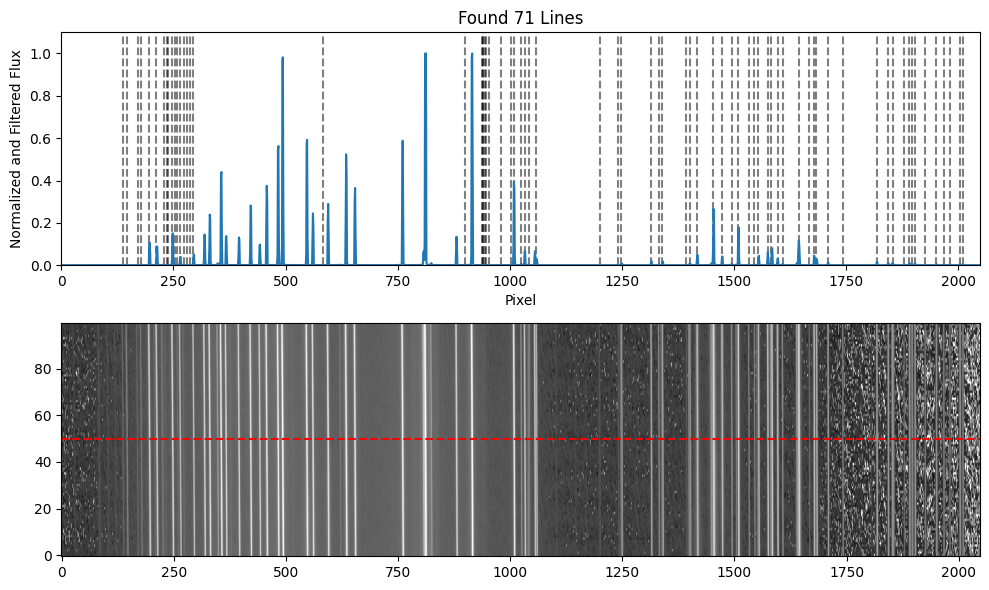

In [6]:
_, _ = ss.find_cal_lines(arclamp, debug=True, std_variation=1)

Notice that several lines from ~300-900 are considered a single feature centered at ~600. If you encounter this error, try increasing the ```std_variation``` argument.

### _Poor Warp Model_

If you notice some weird residuals during your data reduction, it is a good idea to double-check the quality of your warp model. The ```generate_warp_model()``` function makes a handful of assumptions about your image. If your ```tolerance``` is too small or your ``guess`` array only covers a small portion of your image, the resulting model will be poor. For example...

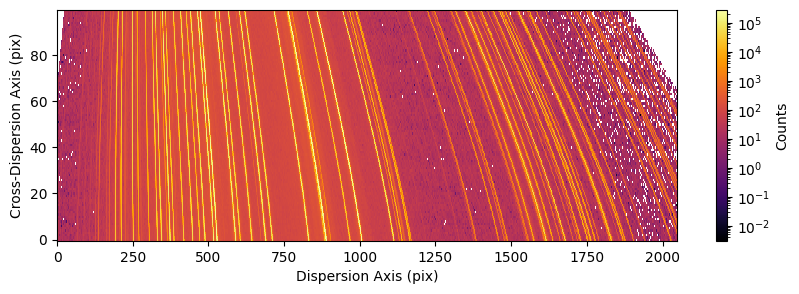

In [7]:
warp_model = ss.generate_warp_model(
    image = arclamp,
    guess = [250, 260, 270],
    tolerance=2,
)

dewarped_image = ss.dewarp_image(
    arclamp,
    warp_model,
)

ss.plot_image(dewarped_image, norm='log')

...shows what a poor warp model can do to your data. You could also diagnose the issue by looking at ```generate_warp_model()```'s debugging plots...

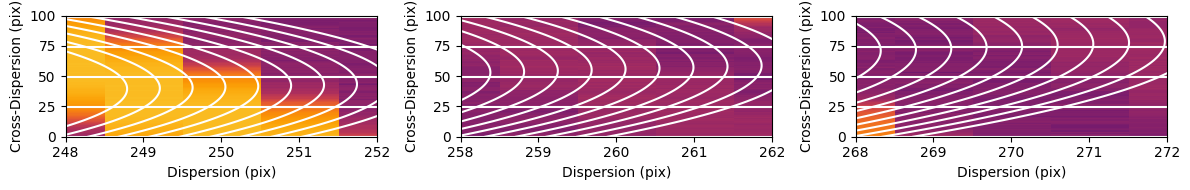

In [8]:
warp_model = ss.generate_warp_model(arclamp, [250, 260, 270], tolerance=2, debug=True)

If you run into this issue, simply try increasing the ```tolerance``` or choose different points for your ```guess``` array.